<a href="https://colab.research.google.com/github/opon13/DeepLearning_course/blob/main/GAN%20Augmentation/gan_augmentation_Pulino_Pontorno.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install matplotlib==3.5 
!pip install captum==0.5
!pip install pytorch-fid
!pip install torchmetrics
!pip install torch-fidelity
!pip install torchmetrics[image]

In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download vipoooool/new-plant-diseases-dataset
!unzip /content/new-plant-diseases-dataset.zip

 

In [ ]:
# Basic python and ML Libraries ORAZIO
import os
import random
import numpy as np
import pandas as pd
# for ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchvision libraries
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image
from torch.utils.data import random_split
from matplotlib import pyplot as plt
from numpy import asarray
from torchmetrics.classification import Accuracy
import PIL
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from IPython.display import clear_output
import captum
from captum.attr import IntegratedGradients, LayerGradCam, LayerAttribution, NoiseTunnel
from captum.attr import visualization as viz
import time
from torchvision.models import resnet18
import torchvision.utils as vutils

import io
import IPython.display
from tqdm.notebook import tqdm
# import the required packages

import argparse
from torch.autograd import Variable
from torchvision.utils import save_image
from torchvision.utils import make_grid
from torch.utils.tensorboard import SummaryWriter
from pytorch_fid.fid_score import calculate_fid_given_paths
from torchmetrics.image.inception import InceptionScore
import torch_fidelity
import uuid
import shutil


%matplotlib inline

from __future__ import print_function
# Set random seed for reproducibility
random_seed=13
random.seed(random_seed)
torch.manual_seed(random_seed)
dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
def set_seed(random_seed):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    #torch.use_deterministic_algorithms(True)
    random.randint(0,10)
    
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

# Dataset Plant

In [ ]:
class plantDataset(Dataset):
    def __init__(self, dset_dir,split='train',data_augm=False,transforms=None):
        self.split = split
        self.dset_dir = Path(dset_dir)/self.split
        
        self.transforms = transforms
        self.files = []
        self.folders = sorted(os.listdir(self.dset_dir))
        if(data_augm):
          self.dset_dir_aug=Path('fake-images')
          self.folders_aug = sorted(os.listdir(self.dset_dir_aug))
          for folder in self.folders_aug:
            class_idx= self.folders_aug.index(folder)
            folder_dir = self.dset_dir_aug/folder
            files = os.listdir(folder_dir)
            self.files += [{"name_class":folder,"file": folder_dir/x, "class": class_idx} for x in files]
        else:
          for folder in self.folders:
              class_idx= self.folders.index(folder)
              folder_dir = self.dset_dir/folder
              files = os.listdir(folder_dir)
              self.files += [{"name_class":folder,"file": folder_dir/x, "class": class_idx} for x in files]
            

    def __len__(self):
        return len(self.files)
    
    def __get_class__(self):
        return(self.folders)
    
    def __getitem__(self, i):
        item = self.files[i]
        file = item['file']
        class_idx= item['class']
        name_class=item['name_class']
        # reading the images and converting them to correct size and color    
        if self.transforms:
            img = Image.open(file).convert("RGB")
            img = self.transforms(img)
            
        return img,class_idx,name_class     
           

## Settings

In [ ]:

workers = 2     # Number of workers for dataloader
batch_size = 64 # Batch size during training
image_size = 64
nc = 3 # Number of channels in the training images. For color images this is 3
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64# Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
num_epochs = 150 # Number of training epochs
lr = 0.0001 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparameter for Adam optimizers

## Transformations

In [ ]:
train_trans = transforms.Compose([
  #transforms.RandomHorizontalFlip(0.5),
  #transforms.RandomVerticalFlip(0.5),
  transforms.Resize([image_size,image_size]),
  transforms.ToTensor(),
  transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
])

test_trans = transforms.Compose([
    transforms.Resize([image_size,image_size]),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
])

## Data Loaders

In [ ]:

dataroot = "New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/"

original = plantDataset(dataroot,split='train',transforms= train_trans)
len_train=300*38
remain_len_train=original.__len__()-len_train
train_dset, unu = random_split(original,[len_train, remain_len_train])

test_original= plantDataset(dataroot, split='valid',transforms= test_trans)
 
len_test=3000
len_test_un=test_original.__len__()-len_test
test_used,_=random_split(test_original,[len_test, len_test_un])

valid_dset,test_dset = random_split(test_used,[1500, 1500])

print(f'train len: {len(train_dset)} \nvalid len: {len(valid_dset)} \ntest len: {len(test_dset)}')


g = torch.Generator()
g.manual_seed(random_seed)

train_loader = DataLoader(
    train_dset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
    worker_init_fn=set_seed(random_seed),
    generator=g
    #collate_fn=collate_fn
)

valid_loader = DataLoader(
    valid_dset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    worker_init_fn=set_seed(random_seed),
    generator=g
    #collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=workers,
    worker_init_fn=set_seed(random_seed),
    generator=g
    #collate_fn=collate_fn
)


train len: 11400 
valid len: 1500 
test len: 1500


In [ ]:

# Function to visualize bounding boxes in the image
def torch_to_pil(img):
    #return torchtrans.ToPILImage()(img).convert('RGB')
    return np.transpose(vutils.make_grid(img, normalize=True),(1,2,0))

def plot_img(df,index,model=None):
    img,class_idx,name_class=df[index]
    print(img.shape)
    print('nome_specie: '+name_class)
    print('label: '+str(class_idx))

    if not (model ==  None): 
      fig,(x1,x2 ) = plt.subplots(1,2)
      fig.set_size_inches(5,5)
      img=torch_to_pil(img)

      noise = torch.randn(1, latent_dim, device=dev)
      labels=torch.tensor(int(class_idx))
      labels = labels.to(dev)
      labels=labels.unsqueeze(0).long()
      
      print(noise.shape)
      print(labels.shape)
      fake_img = generator((noise,labels))
      x1.imshow(img)
      fake_img=torch_to_pil(fake_img.cpu())
      x2.imshow(fake_img)
    else:
      fig,a = plt.subplots(1,1)
      fig.set_size_inches(5,5)
      img=torch_to_pil(img)
      a.imshow(img)



    #print(target['labels'])
    #print(target['boxes'])
    
# plotting the image with bboxes. Feel free to change the index
# function to convert a torchtensor back to PIL image


## Batch Example

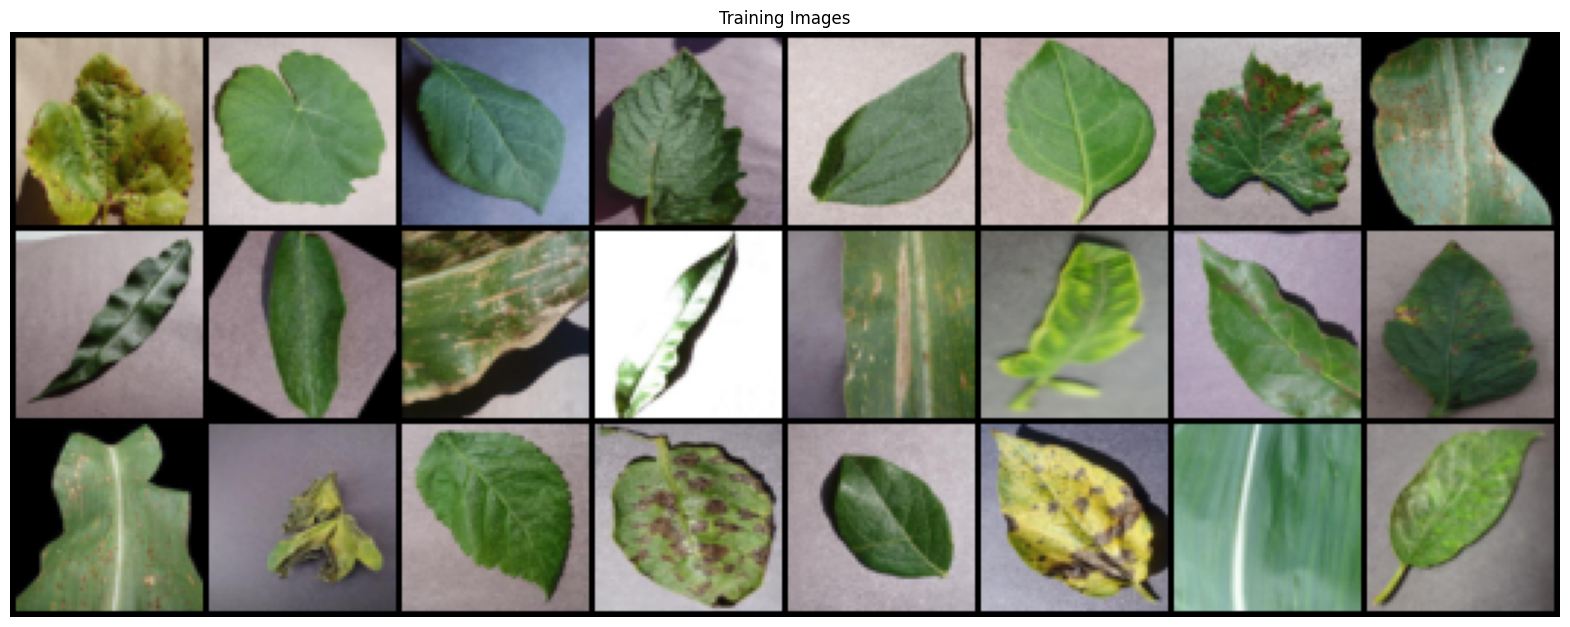

In [ ]:
# Plot some training images
real_batch = next(iter(train_loader))
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:24], padding=2, normalize=True).cpu(),(1,2,0)))

# Classifier ResNet18 without Data Augmentation


## Training Resnet-18 from scratch

In [ ]:
model = resnet18(weights=None)
num_ftrs = model.fc.in_features
nclass=38
# Parameters of newly constructed modules have requires_grad=True by default
model.fc = nn.Linear(num_ftrs, nclass)
model = model.to(dev)

criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.90,weight_decay=0)
# Initialize history
history_loss = {"train": [], "val": [], "test": []}
history_accuracy = {"train": [], "val": [], "test": []}                   

In [ ]:
def train(net, loaders, optimizer, criterion,history_loss,history_accuracy, epochs=num_epochs, dev=torch.device('cpu')):
    try:
        net = net.to(dev)
        #print(net)
        # Process each epoch
        for epoch in range(1,epochs+1):
            start_time_epoch = time.time() #(for showing time)
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0, "test": 0}
            sum_accuracy = {"train": 0, "val": 0, "test": 0}
            # Process each split
            for split in ["train", "val", "test"]:
                if split == "train":
                    net.train()
                else:
                    net.eval()
                # Process each batch
                for (input, labels,name) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    outputs = net(input)
                    loss = criterion(outputs, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    preds = torch.argmax(outputs, 1)
                    batch_accuracy = (preds == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}
            # Update history
            for split in ["train", "val", "test"]:
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            
            
            if(epoch%3 ==0):
                clear_output(wait=True)
                fig, (ax1, ax2) = plt.subplots(1, 2)
                fig.suptitle('Metrics')
                # Plot loss
                ax1.set_title("Loss")
                for split in ["train", "val", "test"]:
                    ax1.plot(history_loss[split], label=split)
                ax1.legend()
                ax1.grid()
                #ax1.show()
                # Plot accuracy
                ax2.set_title("Accuracy")
                for split in ["train", "val", "test"]:
                    ax2.plot(history_accuracy[split], label=split)
                ax2.legend()
                ax2.grid()
                #ax2.show()
                plt.show()

            print(f"Epoch {epoch}:",
                  f"TrL={epoch_loss['train']:.4f},",
                  f"TrA={epoch_accuracy['train']:.4f},",
                  f"VL={epoch_loss['val']:.4f},",
                  f"VA={epoch_accuracy['val']:.4f},",
                  f"TeL={epoch_loss['test']:.4f},",
                  f"TeA={epoch_accuracy['test']:.4f},",
                  f"Time={time.time()- start_time_epoch:.4f}")
    except KeyboardInterrupt:
        print("Interrupted")
   
        

In [ ]:
# Define dictionary of loaders
loaders = {"train": train_loader,
           "val": valid_loader,
           "test": test_loader}
flag_data=False

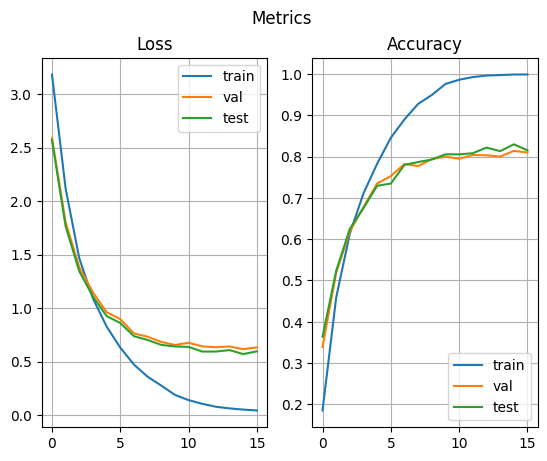

In [ ]:
        
try:
  #load model                      original_classifier.pth
  data_original_model= torch.load('original_classifier.pth')

  model=data_original_model[0]
  history_loss=data_original_model[1]
  history_accuracy=data_original_model[2]

  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.suptitle('Metrics')
  # Plot loss
  ax1.set_title("Loss")
  for split in ["train", "val", "test"]:
      ax1.plot(history_loss[split], label=split)
      ax1.legend()
      ax1.grid()
      
      # Plot accuracy
      ax2.set_title("Accuracy")
  for split in ["train", "val", "test"]:
      ax2.plot(history_accuracy[split], label=split)
      ax2.legend()
      ax2.grid()
               
  plt.show()
except:
  # Train model
  flag_data=True
  train(model, loaders, optimizer, criterion,history_loss=history_loss,history_accuracy=history_accuracy ,epochs=16, dev=dev)

In [ ]:
if(flag_data):
  flag_data=False
  data_original_model=[model,history_loss,history_accuracy]
  torch.save(data_original_model,"original_classifier.pth")

In [ ]:
def get_name_class(index):
    name_classes=original.__get_class__()
    return name_classes[index]
       
    

In [ ]:

from matplotlib import cm

def XAI(ds,index):
    #img, mask,img_,lab = ds[index]#train
    img, lab,name = ds[index]#test
    
    model.eval()
    with torch.no_grad():
        
        inputs = img.unsqueeze(0).to(dev)
        
        outputs = model(inputs)
        prediction_score, pred_label_idx = torch.topk(outputs, 1)
        
        print('prediction:  '+str(pred_label_idx))
        print('prediction name_class:  ' +get_name_class(pred_label_idx))
        print('label:  '+str(lab))
        print('real_name '+name)
   

    
    input_img=inputs
    img=img.numpy()
    for i in range(3):
      img[i,:,:]= (img[i,:,:]-np.min(img[i,:,:]))/(np.max(img[i,:,:])-np.min(img[i,:,:]))

    transformed_img =img
    # Initialize the attribution algorithm with the model
    integrated_gradients = IntegratedGradients(model)

    # Ask the algorithm to attribute our output target to 
    attributions_ig = integrated_gradients.attribute(input_img, target=pred_label_idx, n_steps=400, internal_batch_size=16)

    
    noise_tunnel = NoiseTunnel(integrated_gradients)

    attributions_ig_nt = noise_tunnel.attribute(input_img, nt_samples=10, nt_type='smoothgrad_sq', target=pred_label_idx, internal_batch_size=10,stdevs=0.3)
    _ = viz.visualize_image_attr_multiple(np.transpose(attributions_ig_nt.squeeze().cpu().detach().numpy(), (1,2,0)),
                                      np.transpose(transformed_img, (1,2,0)),
                                      ["original_image", "heat_map"],
                                      ["all", "positive"],
                                      cmap=cm.seismic,
                                      show_colorbar=True)
    
        
    

prediction:  tensor([[3]], device='cuda:0')
prediction name_class:  Apple___healthy
label:  3
real_name Apple___healthy


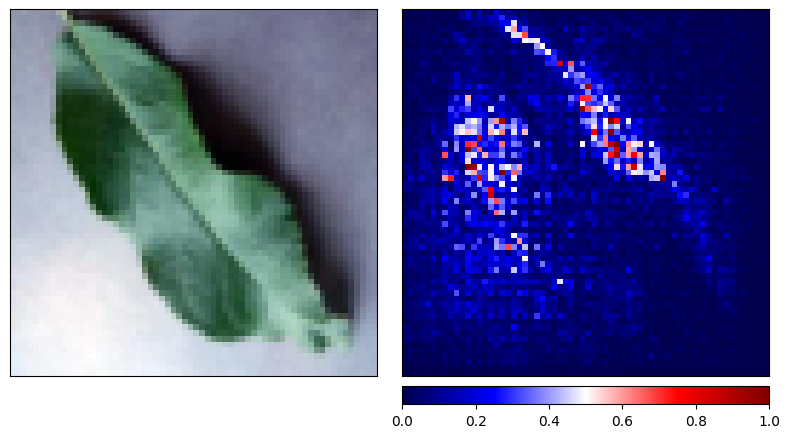

In [ ]:
XAI(train_dset,random.randint(0,len(train_dset)))

# Conditional Deep Convolutional Gan

#Generator

In [ ]:
### *********** 64 SIZE GEN ***************
class Generator(nn.Module):
    def __init__(self,n_classes,embedding_dim,latent_dim):
        super(Generator, self).__init__()

        self.label_conditioned_generator = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 16))

        self.latent = nn.Sequential(nn.Linear(latent_dim, 4*4*512),
                                   nn.LeakyReLU(0.2, inplace=True))

        self.model = nn.Sequential(nn.ConvTranspose2d(513, 64*8, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                      nn.ReLU(True),
                      nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.ReLU(True), 
                      nn.ConvTranspose2d(64*2, 3, 4, 2, 1, bias=False),
                      nn.Tanh())

    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512, 4, 4)
        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        return image

# Discriminator

In [ ]:
# *********** 64 SIZE DISC *********
class Discriminator(nn.Module):
    def __init__(self,n_classes,embedding_dim):
        super(Discriminator, self).__init__()

        self.label_condition_disc = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                      nn.Linear(embedding_dim, 3*64*64))

        self.model = nn.Sequential(nn.Conv2d(6, 64, 4, 2, 1, bias=False),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64, 64*2, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True),
                      nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False),
                      nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                      nn.LeakyReLU(0.2, inplace=True), 
                      nn.Flatten(),
                      nn.Dropout(0.4),
                      nn.Linear(64*8*8*4, 1),
                      nn.Sigmoid())

    def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 3, 64, 64)
        concat = torch.cat((img, label_output), dim=1)
        output = self.model(concat)
        return output

## Settings Net

In [ ]:
# custom weights initialization called on ``Generator`` and ``Discriminator``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
n_classes = 38
embedding_dim = 100
latent_dim = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = Generator(n_classes=n_classes,embedding_dim=embedding_dim,latent_dim=latent_dim).to(device)
discriminator = Discriminator(n_classes=n_classes,embedding_dim=embedding_dim).to(device)
# initialization
generator.apply(weights_init)
discriminator.apply(weights_init)

In [ ]:
discriminator_loss = nn.BCELoss()
generator_loss = nn.BCELoss() 

In [ ]:
G_optimizer = optim.Adam(generator.parameters(), lr=0.001, betas=(beta1, 0.999)) 
D_optimizer = optim.Adam(discriminator.parameters(), lr=0.001,betas=(beta1, 0.999))
D_scheduler = StepLR(D_optimizer, step_size=60, gamma=0.1)
G_scheduler = StepLR(G_optimizer, step_size=60, gamma=0.1)


In [ ]:
def showarray(a, fmt='png'):
    a = (a - a.min())
    a = a /a.max()
    a = np.uint8(a*255)
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

## Dataset to test FID

In [ ]:
fid_trans = transforms.Compose([
  transforms.Resize([image_size,image_size]),
  transforms.ToTensor(),
  #transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

In [ ]:
try:
  shutil.rmtree('plant_images')
except:
  print('ok')
dataset_fid_original=plantDataset(dataroot,split='train',transforms= fid_trans)
len_df_fid=11400
remain_len_df_fid=dataset_fid_original.__len__()-len_df_fid
dataset_fid, _ = random_split(original,[len_df_fid, remain_len_df_fid])
os.makedirs('plant_images')
for idx in tqdm(range(len(dataset_fid))):
    img, label,name = dataset_fid.__getitem__(idx)
    vutils.save_image(img,f"plant_images/{idx}.png",normalize=True)
    #img.save(f"plant_images/{idx}.png")

ok


  0%|          | 0/11400 [00:00<?, ?it/s]

In [ ]:
def normalize_images_IS(images): #IS wants input between [0,1]
    # Normalize a batch of images to be between 0 and 1
    max_value = torch.max(images)
    min_value = torch.min(images)
    normalized_images = (images - min_value) / (max_value - min_value)
    return normalized_images

## Training Conditional DCGAN

In [ ]:
all_fid = []
all_IS_MU = []
all_IS_STD = []
D_loss_avg,G_loss_avg=[],[]
flag_data_Gan=False

In [ ]:
def train_Gan():
  try:
    shutil.rmtree('tmp')
  except:
    print('ok')
  num_epochs = 200
  fid, is_mu, is_std=1000,1000,1000

  for epoch in range(1, num_epochs+1): 
      D_loss_list, G_loss_list = [], []
      start_time_epoch = time.time() #(for showing time)
      running_loss = 0.   #(set loss 0)
      running_corrects = 0 
      for index, (real_images, labels,name) in enumerate(train_loader):
          D_optimizer.zero_grad()
          real_images = real_images.to(device)
          labels = labels.to(device)
          labels = labels.unsqueeze(1).long()
 
       
          real_target = Variable(torch.ones(real_images.size(0), 1).to(device))
          fake_target = Variable(torch.zeros(real_images.size(0), 1).to(device))
       
          D_real_loss = discriminator_loss(discriminator((real_images, labels)), real_target)
        # print(discriminator(real_images))
        #D_real_loss.backward()
     
          noise_vector = torch.randn(real_images.size(0), latent_dim, device=device)  
          noise_vector = noise_vector.to(device)
         
        
          generated_image = generator((noise_vector, labels))
          output = discriminator((generated_image.detach(), labels))
          D_fake_loss = discriminator_loss(output,  fake_target)
     
          # train with fake
          #D_fake_loss.backward()
       
          D_total_loss = (D_real_loss + D_fake_loss) / 2
          D_loss_list.append(D_total_loss.detach().cpu())
       
          D_total_loss.backward()
          D_optimizer.step()
 
          # Train generator with real labels
          G_optimizer.zero_grad()
          G_loss = generator_loss(discriminator((generated_image, labels)), real_target)
          G_loss_list.append(G_loss.detach().cpu())
          # updating weights
          G_loss.backward()
          G_optimizer.step()
        
      # updating scheduler
      g_loss = np.mean(G_loss_list)
      d_loss = np.mean(D_loss_list)
    
      D_loss_avg.append(d_loss)
      G_loss_avg.append(g_loss)
    
      D_scheduler.step()
      G_scheduler.step()
      if(epoch %20 == 0 ):
        # computing FID
          clear_output(wait=True)
          os.makedirs('tmp')
          for _ in tqdm(range(24)):
              with torch.no_grad():
                  noise = torch.randn(500, latent_dim, device=device)
                  labels=torch.randint(0,38,(1,500))
                  labels = labels.to(device)
                  fake_imgs = generator((noise,labels))
              for idx in range(fake_imgs.shape[0]):
                  fake_img = fake_imgs[idx]
                  vutils.save_image(fake_img,f"tmp/{str(uuid.uuid4())}.png",normalize=True)
          fid = calculate_fid_given_paths(['plant_images','tmp'],dims=2048, device = 'cuda',batch_size=100)
          all_fid.append(fid)
          # computing Inception Score
          fake_imgs = normalize_images_IS(fake_imgs.cpu())  #to be sure that values are normalized between [0,1]
          inception = InceptionScore(normalize = True)  #to make the inception score accept values between [0,1]
          inception.update(fake_imgs)

          is_mu = inception.compute()[0]
          is_std = inception.compute()[1]
          # saving values
          all_fid.append(fid)
          all_IS_MU.append(is_mu)
          all_IS_STD.append(is_std)
          shutil.rmtree('tmp')

          # showing images
          grid_img = vutils.make_grid(generated_image.cpu().detach(), nrow=12)
          showarray(grid_img.permute(1, 2, 0))

          # plotting losses 
          plt.plot(D_loss_avg,label='D_loss' )
          plt.plot(G_loss_avg,label='G_loss' )
          plt.legend()
          plt.grid()
          plt.show()

      print('[G_loss #{}] Loss: {:.4f}  Time: {:.4f}s FID={:.4f} IS = mean:{:.2f}, std:{:.2f} '.format(epoch, g_loss, time.time()- start_time_epoch,fid,is_mu, is_std))
      print('[D_loss #{}] Loss: {:.4f}  Time: {:.4f}s'.format(epoch, d_loss, time.time()- start_time_epoch))
      print(f'Epoch: {epoch}/{num_epochs}')
    
    
    

Inception Score:
	 mean: 3.1624107360839844 
	 std: 0.386096715927124
 FID : 71.47648761951285


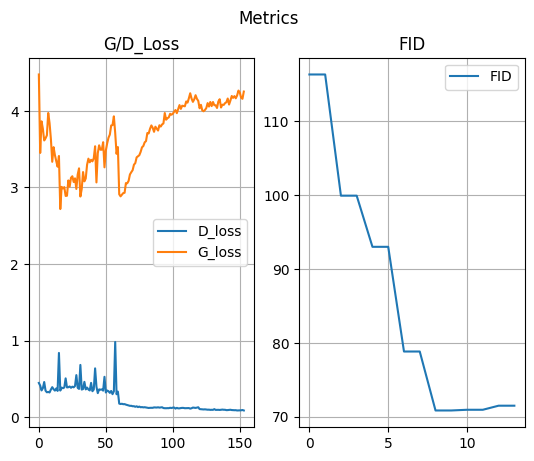

In [ ]:
try:
  #load model
  data_Gan= torch.load('data_Gan2.pth')

  generator=data_Gan[0]
  discriminator=data_Gan[1]
  all_fid=data_Gan[2]
  all_IS_MU=data_Gan[3]
  all_IS_STD=data_Gan[4]
  D_loss_avg=data_Gan[5]
  G_loss_avg=data_Gan[6]
  
  print(f'Inception Score:\n\t mean: {all_IS_MU[-1]} \n\t std: {all_IS_STD[-1]}\n FID : {all_fid[-1]}')
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.suptitle('Metrics')
  # Plot loss
  ax1.set_title("G/D_Loss")

  ax1.plot(D_loss_avg,label='D_loss')
  ax1.plot(G_loss_avg,label='G_loss')
  ax1.legend()
  ax1.grid()
      
      # Plot accuracy
  ax2.set_title("FID")
  ax2.plot(all_fid, label='FID')
  ax2.legend()
  ax2.grid()
  plt.show()
except:
  # Train model
  flag_data_Gan=True
  train_Gan()

In [ ]:
if(flag_data_Gan):
  flag_data_Gan=False
  data_Gan=[generator,discriminator,all_fid,all_IS_MU,all_IS_STD,D_loss_avg,G_loss_avg]
  torch.save(data_Gan,"data_Gan2.pth")

In [ ]:
from google.colab import files
files.download('data_Gan2.pth') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Generating fake images

torch.Size([100, 100])
torch.Size([1, 100])


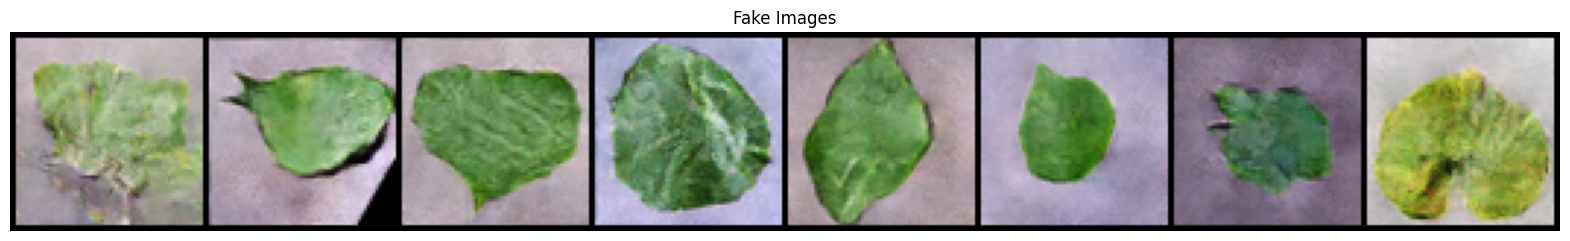

In [ ]:
#generate images
noise = torch.randn(100, latent_dim, device=device)
labels=torch.randint(0,38,(1,100))
labels = labels.to(device)
print(noise.shape)
print(labels.shape)
fake_imgs = generator((noise,labels))
# Plot some training images
plt.figure(figsize=(20,10))
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(fake_imgs[:8], padding=2, normalize=True).cpu(),(1,2,0)))

## Comparing fake images with real images


torch.Size([3, 64, 64])
nome_specie: Apple___Apple_scab
label: 0
torch.Size([1, 100])
torch.Size([1])


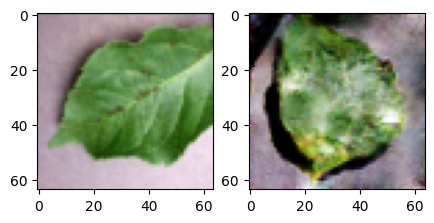

In [ ]:
plot_img(train_dset,random.randint(0,len(train_dset)),generator)

# Combining Original Dataset with the Fake Images

# Creating folder fake images


In [ ]:
try :
  shutil.rmtree('fake-images')
except:
 
  os.makedirs('fake-images')
  for class_idx in range(0,38):
    os.makedirs(f"fake-images/{class_idx}")
    for imgs in range(0,300):
      noise = torch.randn(1, latent_dim,device=dev)
      labels=torch.tensor(int(class_idx))
      labels = labels.to(dev)
      labels=labels.unsqueeze(0).long()
      generator=generator.to(dev)
      fake_img = generator((noise,labels))
      save_image(fake_img,f"fake-images/{class_idx}/{imgs}.png")


# Data Loaders

In [ ]:

dataroot = "New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/"

train_dset_aug = plantDataset(dataroot,split='train',data_augm=True,transforms= train_trans)
train_df_combined = torch.utils.data.ConcatDataset([train_dset, train_dset_aug])


print(f'train len: {len(train_df_combined)} \nvalid len: {len(valid_dset)} \ntest len: {len(test_dset)}')


g = torch.Generator()
g.manual_seed(random_seed)

train_loader_aug = DataLoader(
    train_df_combined,
    batch_size=batch_size,
    shuffle=True,
    num_workers=workers,
    worker_init_fn=set_seed(random_seed),
    generator=g
    #collate_fn=collate_fn
)



train len: 22800 
valid len: 1500 
test len: 1500


# Training Resnet-18 from scratch using Gan generated images

In [ ]:
model_aug = resnet18(weights=None)
num_ftrs = model_aug.fc.in_features
nclass=38
# Parameters of newly constructed modules have requires_grad=True by default
model_aug.fc = nn.Linear(num_ftrs, nclass)
model_aug = model_aug.to(dev)

criterion = nn.CrossEntropyLoss()
# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer = optim.SGD(model_aug.parameters(), lr=0.001, momentum=0.90,weight_decay=0)
# Initialize history
history_loss_aug = {"train": [], "val": [], "test": []}
history_accuracy_aug = {"train": [], "val": [], "test": []}           

In [ ]:
# Define dictionary of loaders
loaders = {"train": train_loader_aug,
           "val": valid_loader,
           "test": test_loader}
flag_data=False

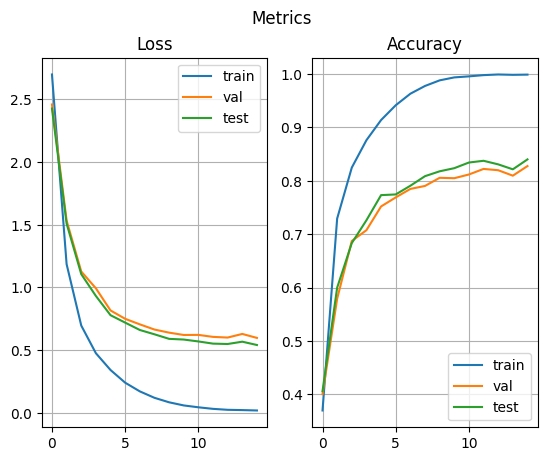

Epoch 15: TrL=0.0194, TrA=0.9990, VL=0.5980, VA=0.8277, TeL=0.5414, TeA=0.8401, Time=41.5211
Epoch 16: TrL=0.0145, TrA=0.9994, VL=0.6013, VA=0.8225, TeL=0.5513, TeA=0.8328, Time=41.1369


In [ ]:

try:
  #load model
  data_original_model= torch.load('aug_classifier.pth')

  model_aug=data_original_model[0]
  history_loss_aug=data_original_model[1]
  history_accuracy_aug=data_original_model[2]

  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.suptitle('Metrics')
  # Plot loss
  ax1.set_title("Loss")
  for split in ["train", "val", "test"]:
      ax1.plot(history_loss_aug[split], label=split)
      ax1.legend()
      ax1.grid()
      
      # Plot accuracy
      ax2.set_title("Accuracy")
  for split in ["train", "val", "test"]:
      ax2.plot(history_accuracy_aug[split], label=split)
      ax2.legend()
      ax2.grid()
               
  plt.show()
except:
  # Train model
  flag_data_aug=True
  train(model_aug, loaders, optimizer, criterion,history_loss=history_loss_aug,history_accuracy=history_accuracy_aug, epochs=16, dev=dev)

In [ ]:
if(flag_data_aug):
  flag_data_aug=False
  data_original_model=[model_aug,history_loss_aug,history_accuracy_aug]
  torch.save(data_original_model,"aug_classifier.pth")

# Comparison Training with and without data Augm


Metrics without using fake Images Loss Test: 0.59593  Accuracy Test: 0.81529
Metrics  using fake Images        Loss Test: 0.55127  Accuracy Test: 0.83278


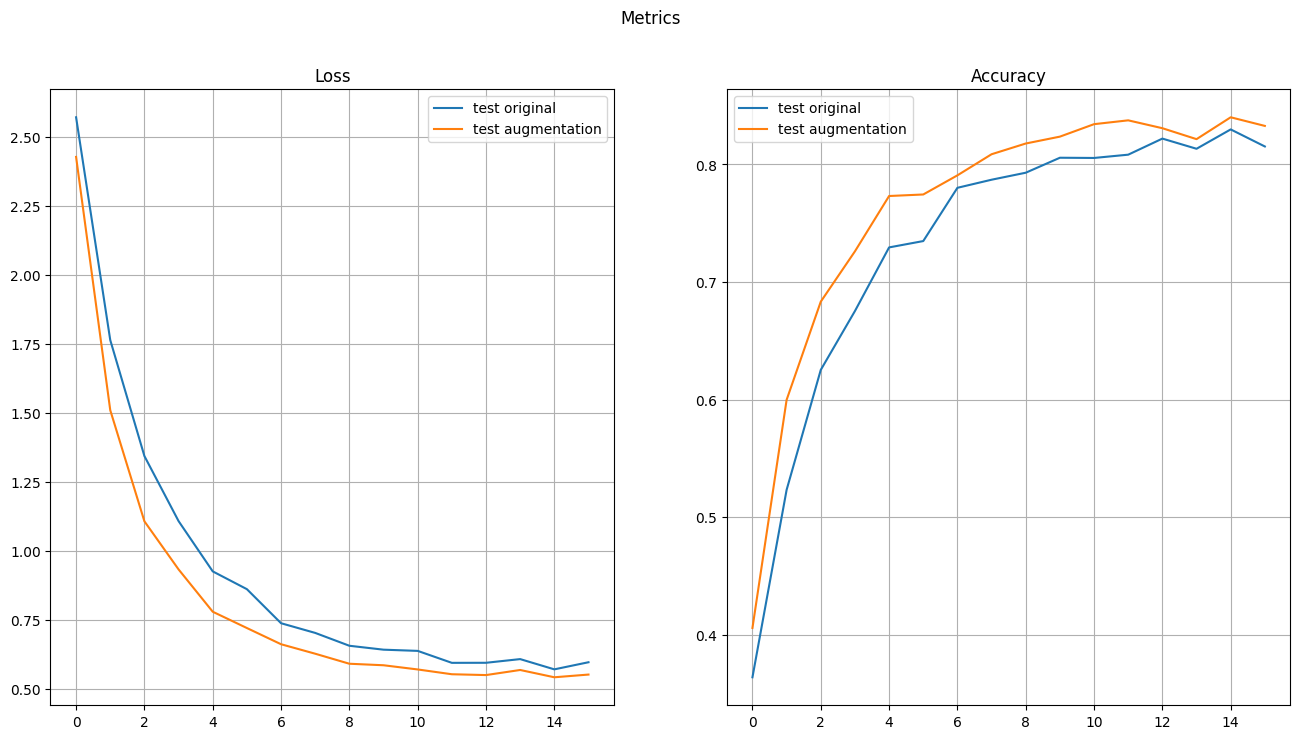

In [ ]:
  print(f'Metrics without using fake Images Loss Test: {round(history_loss["test"][-1],5)}  Accuracy Test: {round(history_accuracy["test"][-1],5)}')
  print(f'Metrics  using fake Images        Loss Test: {round(history_loss_aug["test"][-1],5)}  Accuracy Test: {round(history_accuracy_aug["test"][-1],5)}')
  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(16,8)
  fig.suptitle('Metrics')
  # Plot loss
  ax1.set_title("Loss")
  for split in [ "test"]:
      ax1.plot(history_loss[split], label=split+" original")
      ax1.plot(history_loss_aug[split], label=split+" augmentation")
      ax1.legend()  
  ax1.grid()      
      # Plot accuracy
  ax2.set_title("Accuracy")
  for split in [ "test"]:
      ax2.plot(history_accuracy[split], label=split+" original")
      ax2.plot(history_accuracy_aug[split], label=split+" augmentation")
      ax2.legend()  
  ax2.grid()      
  plt.show()